In [ ]:
import numpy as np
import os
import PIL

import matplotlib.pyplot as plt
import albumentations as A

import PIL.Image
import tensorflow as tf
from tensorflow.keras.layers import (RandomFlip, RandomRotation, RandomCrop, RandomZoom, RandomContrast, Conv2D, MaxPool2D, Flatten, Dense, Input)
from tensorflow.keras import Sequential

In [ ]:
datadir = 'Human-Segmentation-Dataset-master.zip'

In [ ]:
! unzip Human-Segmentation-Dataset-master.zip

Archive:  Human-Segmentation-Dataset-master.zip
fe4efc56003005a58b7d2449aa563a20e3861e24
   creating: Human-Segmentation-Dataset-master/
  inflating: Human-Segmentation-Dataset-master/.DS_Store  
   creating: Human-Segmentation-Dataset-master/Ground_Truth/
  inflating: Human-Segmentation-Dataset-master/Ground_Truth/.DS_Store  
  inflating: Human-Segmentation-Dataset-master/Ground_Truth/1.png  
  inflating: Human-Segmentation-Dataset-master/Ground_Truth/10.png  
  inflating: Human-Segmentation-Dataset-master/Ground_Truth/100.png  
  inflating: Human-Segmentation-Dataset-master/Ground_Truth/101.png  
  inflating: Human-Segmentation-Dataset-master/Ground_Truth/102.png  
  inflating: Human-Segmentation-Dataset-master/Ground_Truth/103.png  
  inflating: Human-Segmentation-Dataset-master/Ground_Truth/104.png  
  inflating: Human-Segmentation-Dataset-master/Ground_Truth/105.png  
  inflating: Human-Segmentation-Dataset-master/Ground_Truth/106.png  
  inflating: Human-Segmentation-Dataset-mast

In [ ]:
import os

input_dir = "Human-Segmentation-Dataset-master/Training_Images"
target_dir = "Human-Segmentation-Dataset-master/Ground_Truth"


img_size = (256, 256)

X = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
y = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png")
    ]
)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [ ]:
transform = A.Compose([A.RandomRotate90(p=.3), A.RandomBrightnessContrast(p=.3), A.VerticalFlip(p=.3),A.HorizontalFlip(p=.3),
                                                                                                  A.ShiftScaleRotate(p=0.3)])


In [ ]:

from tensorflow.keras.preprocessing.image import load_img

class Loader(tf.keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, augment=False):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.augment = augment

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        y = np.zeros((self.batch_size,) + self.img_size, dtype="uint8")
        for j, (img_path, mask_path) in enumerate(zip(batch_input_img_paths, batch_target_img_paths)):
            img = load_img(img_path, target_size=self.img_size)
            mask = load_img(mask_path, target_size=self.img_size, color_mode="grayscale")
            if self.augment:
              transformed = transform(image=np.array(img), mask=np.array(mask))
              img, mask = transformed['image'], transformed['mask']
            x[j] = img
            y[j] = mask

        return x/255.0, y/255.0

In [ ]:
# batch_size = 24
# train_gen = Loader(batch_size, img_size, X_train, y_train, augment=False)
# aug_train_gen = Loader(batch_size, img_size, X_train, y_train, augment=True)
# val_gen = Loader(batch_size, img_size, X_val, y_val, augment=False)
# test_gen = Loader(batch_size, img_size, X_test, y_test, augment=False)

train_batch_size = 16
test_batch_size = 32
train_gen = Loader(train_batch_size, img_size, X_train, y_train, augment=False)
aug_train_gen = Loader(train_batch_size, img_size, X_train, y_train, augment=True)
val_gen = Loader(train_batch_size, img_size, X_val, y_val, augment=False)
test_gen = Loader(test_batch_size, img_size, X_test, y_test, augment=False)

In [ ]:


def plot_samples(data_gen):
  fig, ax = plt.subplots(2, 5)
  fig.set_size_inches((12, 5))
  train_batch = data_gen.__getitem__(0)
  for i in range(5):
      ax[0, i].imshow(train_batch[0][i])
      ax[1, i].imshow(train_batch[1][i], cmap='gray')

      ax[0,i].axis("off")
      ax[1,i].axis("off")

  fig.tight_layout()
  plt.savefig('samples.pdf')
  plt.show()

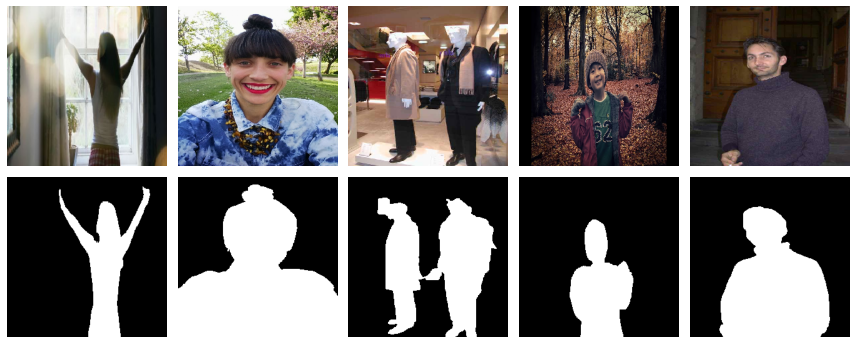

In [ ]:
#### train plot

plot_samples(train_gen)

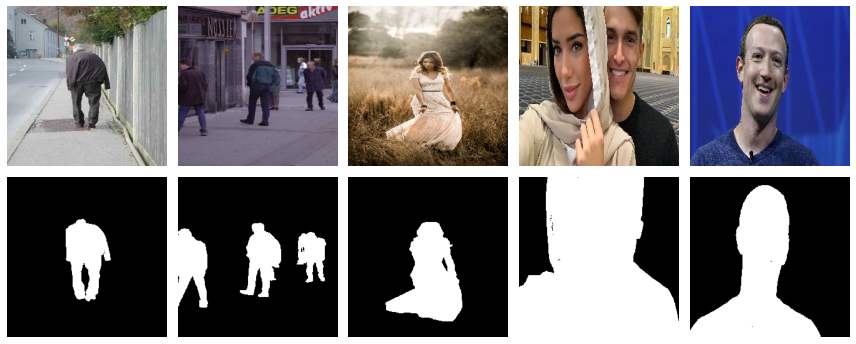

In [ ]:
##test plot

plot_samples(test_gen)

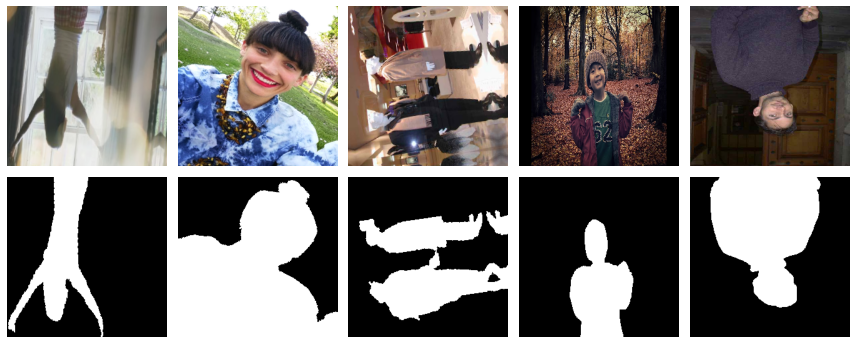

In [ ]:
# data aug

plot_samples(aug_train_gen)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def build_model():
  inputs = Input(img_size + (3,))
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  unet = Model(inputs = inputs, outputs = conv10)

  return unet

In [ ]:

model_1 = build_model()
model_2 = build_model()
model_3 = build_model()


2022-03-28 17:02:29.492321: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-28 17:02:30.236150: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38419 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [ ]:
optimzer = tf.keras.optimizers.Adam(0.0001)

model_1.compile(optimizer=optimzer, loss='binary_crossentropy', metrics=['accuracy'])

model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:

callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)]

history_1 = model_1.fit(train_gen, validation_data  = val_gen , epochs=100, callbacks=callbacks)



Epoch 1/100


2022-03-28 17:02:43.581095: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


10/10 [==============================] - 8s 193ms/step - loss: 0.6931 - accuracy: 0.7159 - val_loss: 0.6928 - val_accuracy: 0.7207 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - 2s 157ms/step - loss: 0.7567 - accuracy: 0.7166 - val_loss: 0.6867 - val_accuracy: 0.7207 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - 2s 157ms/step - loss: 0.6848 - accuracy: 0.7166 - val_loss: 0.6785 - val_accuracy: 0.7207 - lr: 1.0000e-04
Epoch 4/100
10/10 [==============================] - 2s 160ms/step - loss: 0.7318 - accuracy: 0.7166 - val_loss: 0.6891 - val_accuracy: 0.7207 - lr: 1.0000e-04
Epoch 5/100
10/10 [==============================] - 2s 156ms/step - loss: 0.6888 - accuracy: 0.7166 - val_loss: 0.6876 - val_accuracy: 0.7207 - lr: 1.0000e-04
Epoch 6/100
10/10 [==============================] - 2s 158ms/step - loss: 0.6861 - accuracy: 0.7166 - val_loss: 0.6832 - val_accuracy: 0.7207 - lr: 1.0000e-04
Epoch 7/100
10/10 [==============================] -

In [ ]:
# Saving model and History
model_1.save('/content/drive/MyDrive/DNN/Assignment/Assignment 2/dataset/model_1m.h5')

import pickle
with open('/content/drive/MyDrive/DNN/Assignment/Assignment 2/dataset/model_1h.pkl', 'wb+') as h:
 	pickle.dump(history_1,h)


In [ ]:
optimzer = tf.keras.optimizers.Adam(0.0001)


model_2.compile(optimizer=optimzer, loss='binary_crossentropy', metrics=['accuracy'])
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_25 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_24[0][0]']              
                                )                                                           

In [ ]:
optimzer = tf.keras.optimizers.Adam(0.0001)


model_2.compile(optimizer=optimzer, loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)]


history_2 = model_2.fit(aug_train_gen, validation_data  = val_gen, epochs=100, callbacks=callbacks)

Epoch 1/100
10/10 [==============================] - 5s 380ms/step - loss: 0.4607 - accuracy: 0.7944 - val_loss: 0.4315 - val_accuracy: 0.8132 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - 2s 166ms/step - loss: 0.4053 - accuracy: 0.8290 - val_loss: 0.3484 - val_accuracy: 0.8559 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - 2s 164ms/step - loss: 0.3498 - accuracy: 0.8521 - val_loss: 0.3130 - val_accuracy: 0.8697 - lr: 1.0000e-04
Epoch 4/100
10/10 [==============================] - 2s 165ms/step - loss: 0.3399 - accuracy: 0.8559 - val_loss: 0.3390 - val_accuracy: 0.8538 - lr: 1.0000e-04
Epoch 5/100
10/10 [==============================] - 2s 166ms/step - loss: 0.3229 - accuracy: 0.8610 - val_loss: 0.3201 - val_accuracy: 0.8671 - lr: 1.0000e-04
Epoch 6/100
10/10 [==============================] - 2s 164ms/step - loss: 0.3185 - accuracy: 0.8706 - val_loss: 0.3361 - val_accuracy: 0.8641 - lr: 1.0000e-04
Epoch 7/100
10/10 [=====================

In [ ]:
# Saving model and History
model_2.save('/content/drive/MyDrive/dataset/model_2m.h5')

import pickle
with open('/content/drive/MyDrive/dataset/model_2h.pkl', 'wb+') as h:
 	pickle.dump(history_2,h)


In [ ]:
optimzer = tf.keras.optimizers.Adam(0.001)


model_3.compile(optimizer=optimzer, loss='binary_crossentropy', metrics=['accuracy'])
model_3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_49 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_48[0][0]']              
                                )                                                           

In [ ]:
optimzer = tf.keras.optimizers.Adam(0.001)


model_3.compile(optimizer=optimzer, loss='categorical_crossentropy', metrics=['accuracy'])
            
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode = 'min'), 
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)]

history_3 = model_3.fit(aug_train_gen, validation_data  = val_gen, epochs=100, callbacks=callbacks)

Epoch 1/100
10/10 [==============================] - 3s 192ms/step - loss: 407.2925 - accuracy: 0.2869 - val_loss: 396.4599 - val_accuracy: 0.2793 - lr: 0.0010
Epoch 2/100
10/10 [==============================] - 2s 162ms/step - loss: 406.1147 - accuracy: 0.4713 - val_loss: 396.4599 - val_accuracy: 0.7207 - lr: 0.0010
Epoch 3/100
10/10 [==============================] - 2s 163ms/step - loss: 412.4615 - accuracy: 0.7094 - val_loss: 396.4599 - val_accuracy: 0.7207 - lr: 0.0010
Epoch 4/100
10/10 [==============================] - 2s 162ms/step - loss: 407.8033 - accuracy: 0.7127 - val_loss: 396.4599 - val_accuracy: 0.7207 - lr: 0.0010
Epoch 5/100
10/10 [==============================] - 2s 162ms/step - loss: 406.0228 - accuracy: 0.7140 - val_loss: 396.4599 - val_accuracy: 0.7207 - lr: 0.0010
Epoch 6/100
10/10 [==============================] - ETA: 0s - loss: 409.4183 - accuracy: 0.7116
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
10/10 [===================

In [ ]:
def plot_accuray(history):
  plt.figure(figsize=(12, 8))
  plt.title('Model Accuracy')
  plt.plot(history.history['accuracy'], color='g', label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], color='b', label='Val Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.savefig('Model Accuracy.png')
  plt.savefig('Model Accuracy.pdf')
  plt.show()

def plot_loss(history):
  plt.figure(figsize=(12, 8))
  plt.title('Model Loss')
  plt.plot(history.history['loss'], color='g', label='Train Loss')
  plt.plot(history.history['val_loss'], color='b', label='Val Loss')
  plt.xlabel('Epochs')
  plt.ylabel('binary crossentropy')
  plt.legend()
  plt.savefig('Model Loss.png')
  plt.savefig('Model Loss.pdf')
  plt.show()

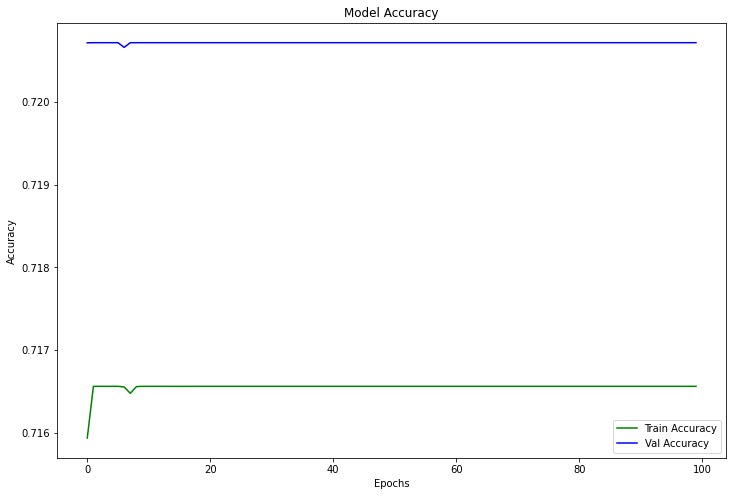

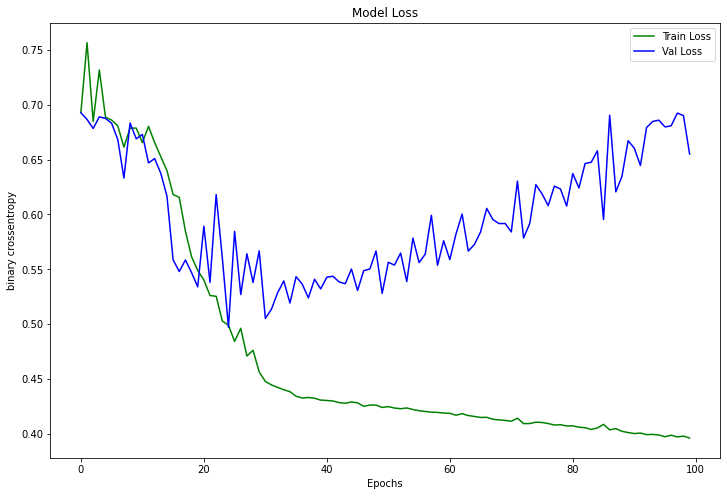

In [ ]:
plot_accuray(history_1)
plot_loss(history_1)


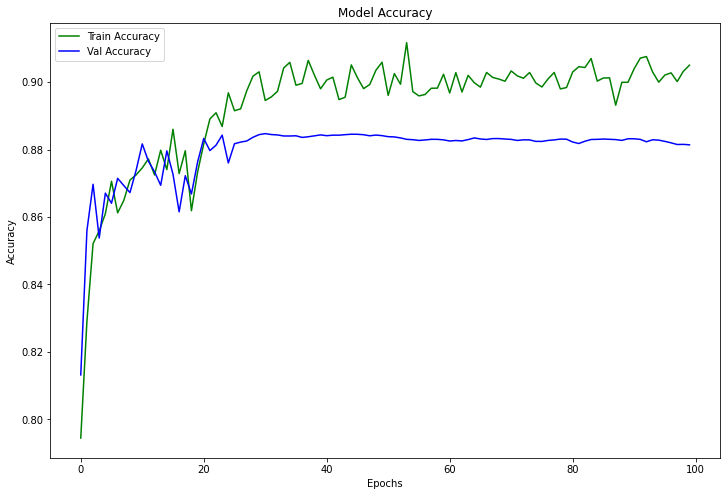

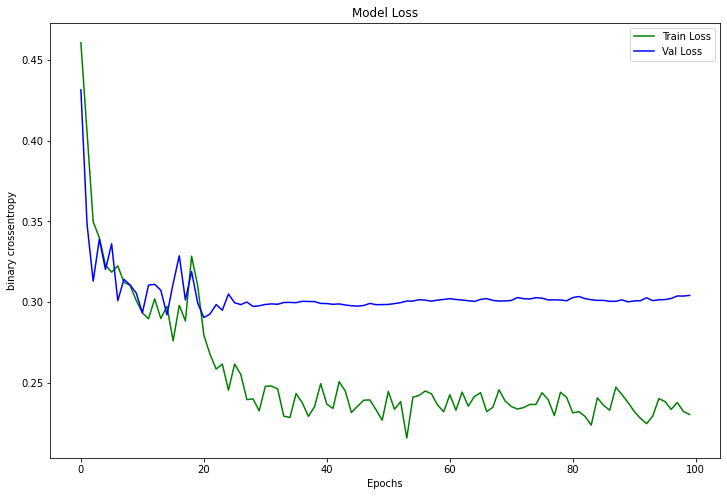

In [ ]:

plot_accuray(history_2)
plot_loss(history_2)


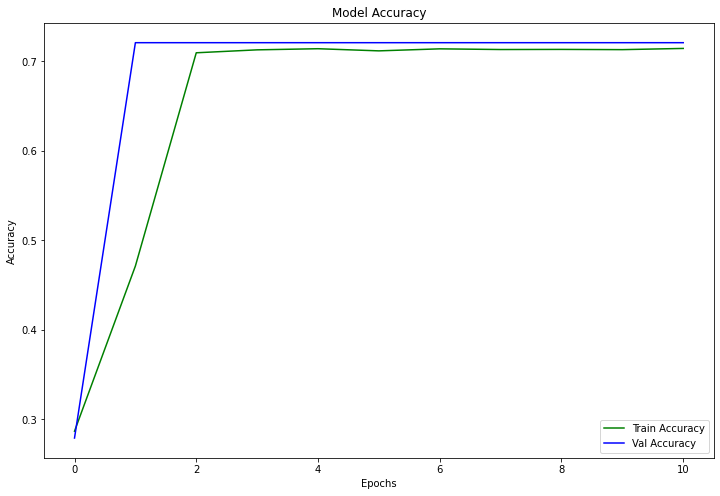

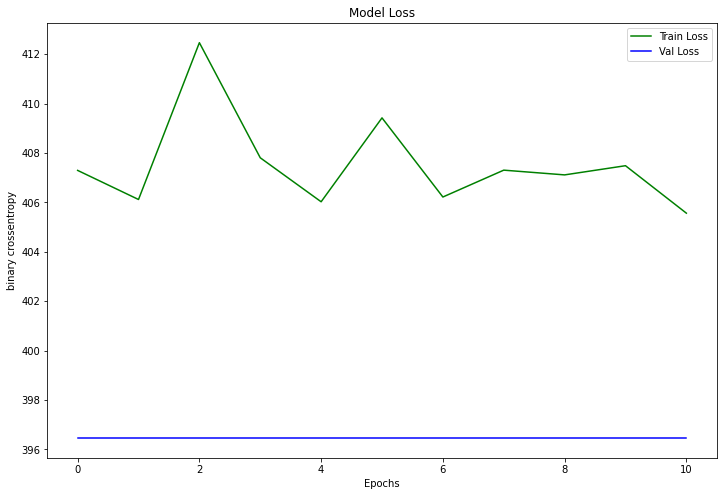

In [ ]:

plot_accuray(history_3)
plot_loss(history_3)